In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
import matplotlib as mpl

#### 데이터 : MNIST

In [28]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version = 1)
# mnist
mnist.target

C:\Anaconda3\lib\site-packages\sklearn\datasets\_openml.py:932: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


0        5
1        0
2        4
3        1
4        9
        ..
69995    2
69996    3
69997    4
69998    5
69999    6
Name: class, Length: 70000, dtype: category
Categories (10, object): ['0', '1', '2', '3', ..., '6', '7', '8', '9']

In [29]:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

#### 데이터셋 확인작업

In [30]:
X= mnist["data"]
y = mnist["target"]
X,y

(       pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  pixel9  \
 0         0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
 1         0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
 2         0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
 3         0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
 4         0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
 ...       ...     ...     ...     ...     ...     ...     ...     ...     ...   
 69995     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
 69996     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
 69997     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
 69998     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
 69999     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
 
        pixel1

In [31]:
X.shape, y.shape

((70000, 784), (70000,))

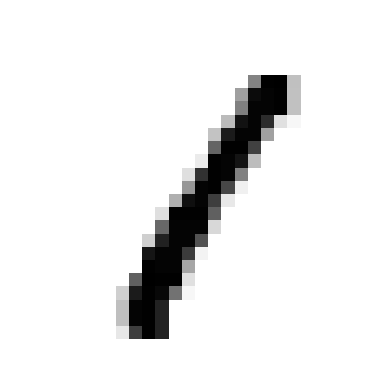

In [32]:
example = X.to_numpy()[3]
example_image = example.reshape(28, 28)
plt.imshow(example_image, cmap="binary")
plt.axis("off")
plt.show()

In [33]:
y[3]

'1'

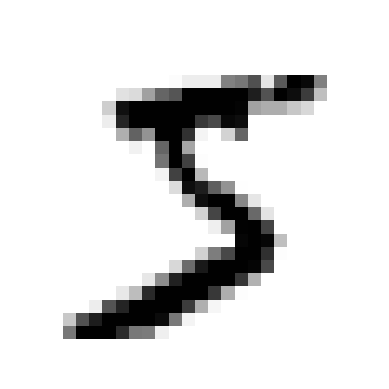

In [34]:
example = X.to_numpy()[0]
example_image = example.reshape(28, 28)
plt.imshow(example_image, cmap="binary")
plt.axis("off")
plt.show()

In [35]:
y = y.astype(np.uint8)
y
# 레이블 정수로 변환

0        5
1        0
2        4
3        1
4        9
        ..
69995    2
69996    3
69997    4
69998    5
69999    6
Name: class, Length: 70000, dtype: uint8

In [36]:
# 훈련셋/검증셋 분리
X_train, X_test = X[:60000], X[60000:]
y_train, y_test = y[:60000], y[60000:]
# 분리

In [37]:
# 이진 분류기 학습

y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [38]:
from sklearn.linear_model import SGDClassifier
# sgd 분류기 진행
sgd_clf = SGDClassifier(random_state =1)

In [39]:
# 훈련
sgd_clf.fit(X_train, y_train_5)


SGDClassifier(random_state=1)

In [40]:
# 예측 진행
sgd_clf.predict([example])
# 이 숫자가 5를 나타낼 확률

C:\Anaconda3\lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([ True])

In [60]:
# kfold 검증
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
skfolds = StratifiedKFold(n_splits=3, random_state = 4, shuffle=True)


In [69]:
for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train.iloc[train_index]
    y_train_folds = y_train_5.iloc[train_index]
    X_test_fold = X_train.iloc[test_index]
    y_test_fold= y_train.iloc[test_index]
    # 학습
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct/len(y_pred))

0.09635
0.09715
0.09715


#### 평가-정확도 계산

In [62]:
# cross valid score 계산
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95785, 0.9667 , 0.9608 ])

In [67]:
# 더미 분류기 생성
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self   
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
never_5_clf = Never5Classifier()
never_5_clf

Never5Classifier()

In [68]:
# cross val score
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

In [70]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

#### 두번째 평가 - confusion matrix

In [74]:
from sklearn.metrics import confusion_matrix

matrix = confusion_matrix(y_train_5, y_train_pred)
matrix

array([[53603,   976],
       [ 1317,  4104]], dtype=int64)

#### 요약 정리


-----
TN | FP |

-----------|

FN | TP |

-----------| 정밀도

재현율

In [77]:
# 1) 정밀도 계산
from sklearn.metrics import precision_score , recall_score
precision_score(y_train_5, y_train_pred)

0.8078740157480315

In [78]:
# 2) 재현율 계산
recall_score(y_train_5, y_train_pred)

0.7570558937465413

In [79]:
# 3) F스코어 계산
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7816398438243977

#### 정밀도/재현율 trade-off


In [83]:
y_scores = sgd_clf.decision_function([example])
y_scores
threshold = 0
y_example_pred = (y_scores > threshold)
y_example_pred

C:\Anaconda3\lib\site-packages\sklearn\base.py:409: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([ True])

In [85]:
y_scores
threshold = 8000
y_example_pred = (y_scores > threshold)
y_example_pred

array([False])

In [88]:
# cross val predict 사용

y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")
y_scores, y_example_pred


(array([  8536.87948485,  -9930.42427547, -34430.63925683, ...,
          6041.93526298,  -4785.17366605,  -8938.21271251]),
 array([False]))

C:\Users\임채원\AppData\Local\Temp\ipykernel_41396\1211909370.py:8: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "b--" (-> linestyle='--'). The keyword argument will take precedence.
  plt.plot(thresholds, precisions[:-1], "b--",
C:\Users\임채원\AppData\Local\Temp\ipykernel_41396\1211909370.py:10: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "r-" (-> linestyle='-'). The keyword argument will take precedence.
  plt.plot(thresholds, recalls[:-1], "r-", label="recall",linewidth=2, markersize=1, alpha=0.5, linestyle='dashed')


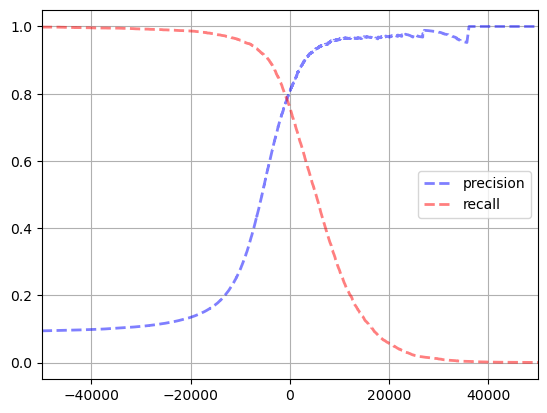

<Figure size 2000x1300 with 0 Axes>

In [127]:
#정밀도 - 재현율 커브
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

def plot_precision_recall_threshold(precisions, recalls, thresholds):
    plt.xlim([-50000, 50000])    
    plt.plot(thresholds, precisions[:-1], "b--", label="precision", linewidth=2, markersize=1, alpha=0.5, linestyle='dashed')
    plt.plot(thresholds, recalls[:-1], "r-", label="recall",linewidth=2, markersize=1, alpha=0.5, linestyle='dashed')
    plt.legend()
    plt.figure(figsize=(20,13))
    
    
plot_precision_recall_threshold(precisions, recalls, thresholds)
plt.show()

In [128]:
# 정밀도 90의 예시
threshold_90_precision = thresholds[np.argmax(precisions >= 0.9)]
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [129]:
# 90%일때 스코어
precision_score(y_train_5,y_train_pred_90)

0.9001088731627653

In [130]:
recall_score(y_train_5,y_train_pred_90)
# 재현율

0.6100350488839698

In [131]:
# 정밀도 80의 예시
threshold_80_precision = thresholds[np.argmax(precisions >= 0.8)]
y_train_pred_80 = (y_scores >= threshold_80_precision)

In [132]:
# 80%일때 스코어
precision_score(y_train_5,y_train_pred_80)

0.800038454143434

In [133]:
recall_score(y_train_5,y_train_pred_80)
# 재현율

0.7675705589374654

#### ROC 곡선

In [134]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5,y_scores)

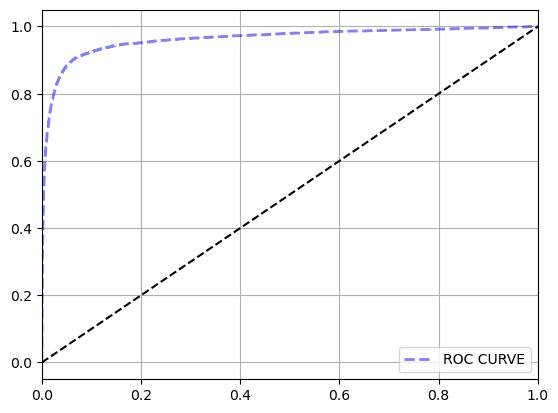

<Figure size 2000x1300 with 0 Axes>

In [156]:
def Roc_curve(fpr, tpr, label=None):
    plt.xlim([0, 1.0])    
    plt.plot(fpr, tpr, "b", label=label, linewidth=2, markersize=1, alpha=0.5, linestyle='dashed')
    plt.plot([0,1],[0,1],"k--")
    plt.legend()
    plt.figure(figsize=(20,13))
    
Roc_curve(fpr, tpr, label="ROC CURVE")
plt.show()

In [147]:
# auc 측정
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5,y_scores)

0.962647024223004

#### 랜덤 포레스트 사용

In [148]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier()
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv = 3, method="predict_proba")
y_probas_forest

array([[0.17, 0.83],
       [0.99, 0.01],
       [0.98, 0.02],
       ...,
       [0.05, 0.95],
       [0.93, 0.07],
       [0.92, 0.08]])

In [150]:
# positive 클래스를 점수로 사용
y_scores_forest = y_probas_forest[:,1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)


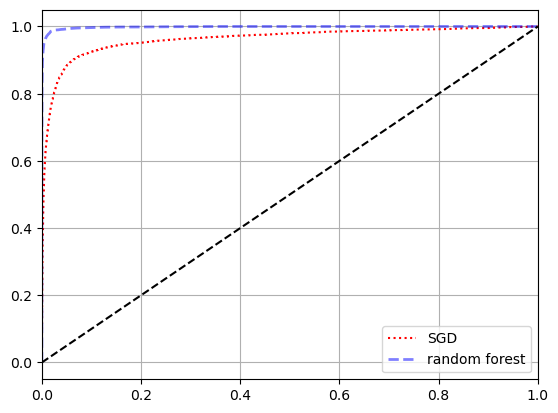

<Figure size 2000x1300 with 0 Axes>

In [158]:
plt.plot(fpr, tpr, "r:", label="SGD")
Roc_curve(fpr_forest, tpr_forest, label="random forest")
plt.show()

In [159]:
# auc 점수 계산
roc_auc_score(y_train_5, y_scores_forest)

0.9983033804744424